# Demonstrate how users will access CESM-LENS data on AWS via intake-esm

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import intake
from distributed.utils import format_bytes
import matplotlib.pyplot as plt

## Connect to intake-esm database

In [2]:
col = intake.open_esm_metadatastore(collection_name="AWS-CESM1-LE") 

In [3]:
col.df.head()

,resource,resource_type,direct_access,experiment,frequency,component,variable,store_fullpath,store_basename,store_bucketname
0,AWS-public-dataset:S3-MAIN-BUCKET:aws-s3:/glad...,aws-s3,True,20C,monthly,lnd,FSNO,/glade/scratch/abanihi/lens-aws/cesmLE-20C-lnd...,cesmLE-20C-lnd-monthly-FSNO.zarr,/glade/scratch/abanihi/lens-aws/
1,AWS-public-dataset:S3-MAIN-BUCKET:aws-s3:/glad...,aws-s3,True,20C,monthly,lnd,QRUNOFF,/glade/scratch/abanihi/lens-aws/cesmLE-20C-lnd...,cesmLE-20C-lnd-monthly-QRUNOFF.zarr,/glade/scratch/abanihi/lens-aws/
2,AWS-public-dataset:S3-MAIN-BUCKET:aws-s3:/glad...,aws-s3,True,20C,monthly,lnd,H2OSNO,/glade/scratch/abanihi/lens-aws/cesmLE-20C-lnd...,cesmLE-20C-lnd-monthly-H2OSNO.zarr,/glade/scratch/abanihi/lens-aws/
3,AWS-public-dataset:S3-MAIN-BUCKET:aws-s3:/glad...,aws-s3,True,RCP85,monthly,lnd,SOILWATER_10CM,/glade/scratch/abanihi/lens-aws/cesmLE-RCP85-l...,cesmLE-RCP85-lnd-monthly-SOILWATER_10CM.zarr,/glade/scratch/abanihi/lens-aws/
4,AWS-public-dataset:S3-MAIN-BUCKET:aws-s3:/glad...,aws-s3,True,RCP85,monthly,lnd,H2OSNO,/glade/scratch/abanihi/lens-aws/cesmLE-RCP85-l...,cesmLE-RCP85-lnd-monthly-H2OSNO.zarr,/glade/scratch/abanihi/lens-aws/


In [4]:
def collection_summary(col):
    df = col.df
    print("There are:\n")
    print(f"\t1) {df.experiment.nunique()} experiments: \n\n\t\t{df.experiment.unique()}\n")
    print(f"\t3) {df.component.nunique()} components: \n\n\t\t{df.component.unique()}\n")
    print(f"\t4) {df.frequency.nunique()} frequencies: \n\n\t\t{df.frequency.unique()}\n")
    print(f"\t5) {df.variable.nunique()} variables: \n\n\t\t{df.variable.unique()} etc...\n")
    

In [5]:
collection_summary(col)

There are:

	1) 2 experiments: 

		['20C' 'RCP85']

	3) 1 components: 

		['lnd']

	4) 1 frequencies: 

		['monthly']

	5) 7 variables: 

		['FSNO' 'QRUNOFF' 'H2OSNO' 'SOILWATER_10CM' 'RAIN' 'SNOW' 'SOILLIQ'] etc...



## Querying and Loading data into xarray datasets

In [6]:
cat = col.search(variable=['FSNO', 'RAIN', 'SNOW', 'SOILLIQ'])

In [7]:
dsets = cat.to_xarray()

**Note:**
    
`to_xarray()` method returns a dictionary of xarray datasets. The keys in this dictionary are constructed as follows:

```key=<experiment>.<component>.<frequency>```




In [8]:
dsets.keys()

dict_keys(['20C.lnd.monthly', 'RCP85.lnd.monthly'])

In [9]:
ds_rcp85 = dsets['RCP85.lnd.monthly']
ds_rcp85

<xarray.Dataset>
Dimensions:       (hist_interval: 2, lat: 192, levgrnd: 15, levlak: 10, lon: 288, member_id: 40, time: 1140)
Coordinates:
  * lat           (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * levgrnd       (levgrnd) float32 0.007100635 0.027925 ... 21.32647 35.17762
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.325 44.775
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.25 357.5 358.75
  * member_id     (member_id) int64 1 2 3 4 5 6 7 ... 34 35 101 102 103 104 105
  * time          (time) object 2006-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: hist_interval
Data variables:
    BSW           (levgrnd, lat, lon) float32 dask.array<shape=(15, 192, 288), chunksize=(1, 192, 288)>
    DZSOI         (levgrnd, lat, lon) float32 dask.array<shape=(15, 192, 288), chunksize=(1, 192, 288)>
    FSNO          (member_id, time, lat, lon) float32 dask.array<shape=(40, 1140, 192, 288), chunksize=(40, 12, 192, 2

In [10]:
format_bytes(ds_rcp85.nbytes)

'181.57 GB'

In [11]:
ds_rcp85.info()

xarray.Dataset {
dimensions:
	hist_interval = 2 ;
	lat = 192 ;
	levgrnd = 15 ;
	levlak = 10 ;
	lon = 288 ;
	member_id = 40 ;
	time = 1140 ;

variables:
	float32 BSW(levgrnd, lat, lon) ;
		BSW:long_name = slope of soil water retention curve ;
		BSW:units = unitless ;
	float32 DZSOI(levgrnd, lat, lon) ;
		DZSOI:long_name = soil thickness ;
		DZSOI:units = m ;
	float32 FSNO(member_id, time, lat, lon) ;
		FSNO:cell_methods = time: mean ;
		FSNO:long_name = fraction of ground covered by snow ;
		FSNO:units = unitless ;
	float32 HKSAT(levgrnd, lat, lon) ;
		HKSAT:long_name = saturated hydraulic conductivity ;
		HKSAT:units = unitless ;
	float32 SUCSAT(levgrnd, lat, lon) ;
		SUCSAT:long_name = saturated soil matric potential ;
		SUCSAT:units = mm ;
	float32 WATSAT(levgrnd, lat, lon) ;
		WATSAT:long_name = saturated soil water content (porosity) ;
		WATSAT:units = mm3/mm3 ;
	float32 ZSOI(levgrnd, lat, lon) ;
		ZSOI:long_name = soil depth ;
		ZSOI:units = m ;
	float32 area(lat, lon) ;
		area:lo

## Make Quick plots with xarray

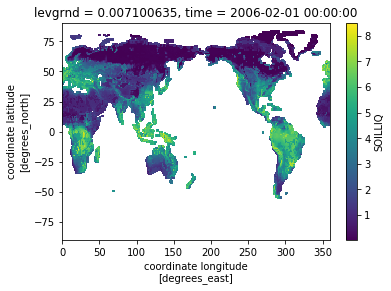

In [12]:
ds_rcp85.SOILLIQ.isel(time=0, levgrnd=0).mean('member_id').plot()

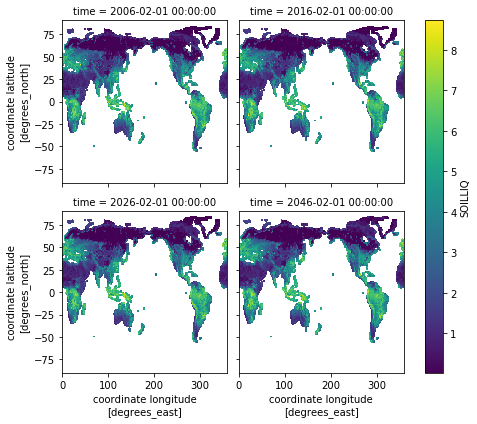

In [13]:
ds_rcp85.SOILLIQ.isel(time=[0, 120, 240, 480], levgrnd=0).mean('member_id').plot(col='time', col_wrap=2)

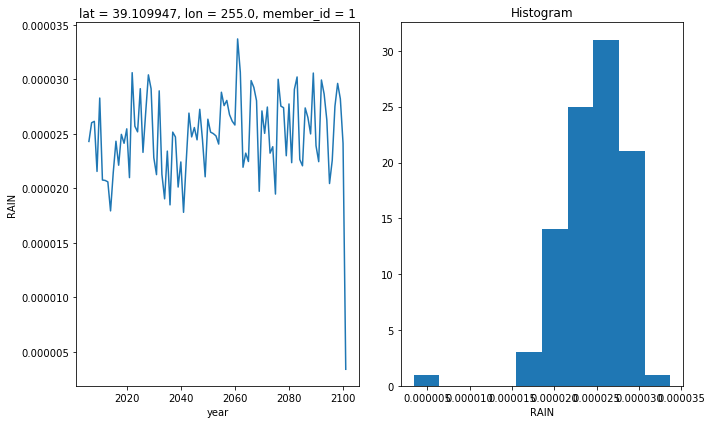

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 6))
co_atm_rain = ds_rcp85.RAIN.sel(member_id=0, lat=39, lon=255, method='nearest').groupby('time.year').mean()
co_atm_rain.plot(ax=axes[0])
co_atm_rain.plot.hist(ax=axes[1])
plt.tight_layout()
plt.draw()